In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_2.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_7.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_5.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_10.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_1.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_8.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_3.JPG
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_6.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_9.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/I

# DATA LOAD

In [ ]:
train_dir = '/kaggle/input/fruit-and-vegetable-image-recognition/train'
test_dir = '/kaggle/input/fruit-and-vegetable-image-recognition/test'
val_dir = '/kaggle/input/fruit-and-vegetable-image-recognition/validation'

In [ ]:
batch_size = 32
image_size = 160

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(image_size, image_size),
                                                                 batch_size=batch_size)

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                 image_size=(image_size, image_size),
                                                                 batch_size=batch_size)

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


In [ ]:
class_name = train_data.class_names
print(class_name)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


image samples visualization

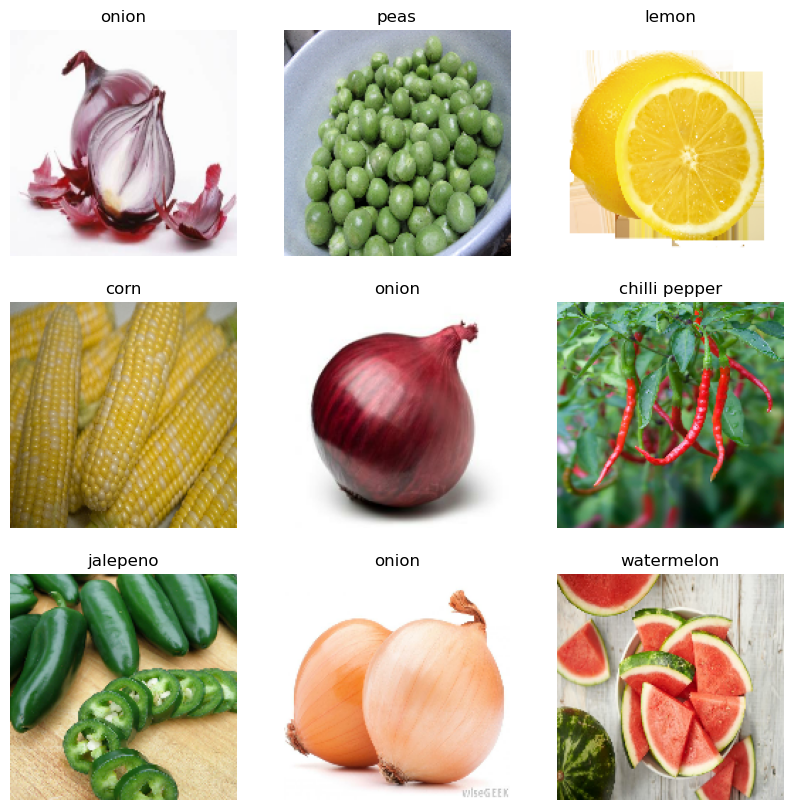

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])
    plt.axis('off')


check the shape of data

In [ ]:
for image_batch, label_batch in train_data:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [ ]:
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 255.0


make data between 0-1

In [ ]:
def format(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255.0
  return image, label

In [ ]:
train = train_data.map(format)
validation = val_data.map(format)

In [ ]:
for format_image_batch, format_label_batch in train:
  print(format_image_batch.shape)
  print(format_label_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [ ]:
format_first_image = format_image_batch[0]
print(np.min(format_first_image), np.max(format_first_image))

0.0 1.0


# MODELING

use MobileNetV2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (image_size, image_size, 3),
                                               include_top = False,
                                               weights = 'imagenet')

size check

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = keras.layers.Dense(36)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 36)


In [ ]:
model = tf.keras.Sequential([
        base_model,
        global_average_layer,
        prediction_layer
])

In [ ]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train,
                    epochs=20,
                    validation_data=validation)

Epoch 1/20
98/98 [==============================] - 85s 619ms/step - loss: 1.9483 - accuracy: 0.5063 - val_loss: 0.8324 - val_accuracy: 0.7379
Epoch 2/20
98/98 [==============================] - 68s 630ms/step - loss: 0.6216 - accuracy: 0.8363 - val_loss: 0.5299 - val_accuracy: 0.8205
Epoch 3/20
98/98 [==============================] - 65s 596ms/step - loss: 0.2855 - accuracy: 0.9316 - val_loss: 0.3582 - val_accuracy: 0.8860
Epoch 4/20
98/98 [==============================] - 66s 606ms/step - loss: 0.1532 - accuracy: 0.9660 - val_loss: 0.2937 - val_accuracy: 0.9231
Epoch 5/20
98/98 [==============================] - 66s 607ms/step - loss: 0.0939 - accuracy: 0.9795 - val_loss: 0.2759 - val_accuracy: 0.9345
Epoch 6/20
98/98 [==============================] - 67s 616ms/step - loss: 0.0647 - accuracy: 0.9846 - val_loss: 0.2085 - val_accuracy: 0.9402
Epoch 7/20
98/98 [==============================] - 67s 615ms/step - loss: 0.0576 - accuracy: 0.9846 - val_loss: 0.1882 - val_accuracy: 0.9373

# MODEL EVALUATE

In [ ]:
def plot_graghs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

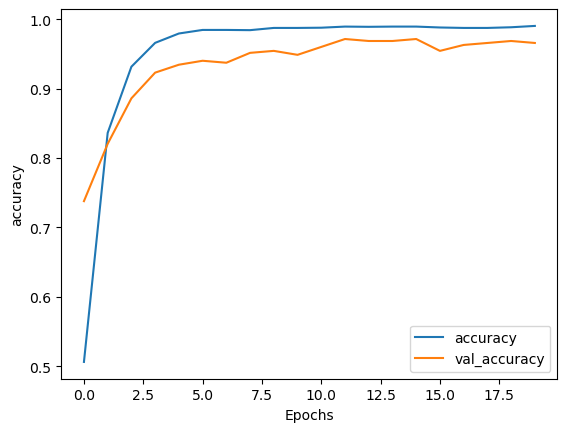

In [ ]:
plot_graghs(history, 'accuracy')

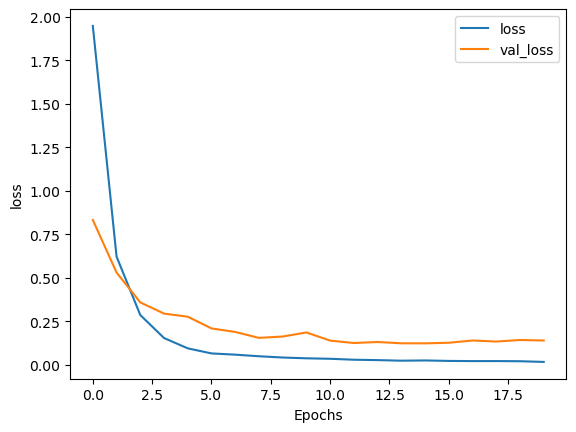

In [ ]:
plot_graghs(history, 'loss')

In [ ]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(image_size, image_size),
                                                                batch_size = batch_size,
                                                                shuffle=False)

Found 359 files belonging to 36 classes.


# TEST

In [ ]:
test = test_data.map(format)

In [ ]:
result = model.evaluate(test)
print("Test loss, Test accuracy : ", result)

12/12 [==============================] - 8s 641ms/step - loss: 0.1360 - accuracy: 0.9666
Test loss, Test accuracy :  [0.1359640210866928, 0.9665738344192505]
